In [143]:
conda install -c conda-forge wordcloud=1.6.0 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/wenyi/opt/anaconda3

  added / updated specs:
    - wordcloud=1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py38h50d1736_0        16.9 MB  conda-forge
    openssl-1.1.1h             |       haf1e3a3_0         1.9 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    wordcloud-1.6.0            |   py38h0b31af3_0         168 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        18.9 MB

In [144]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
##import yfinance as yf
import re
import requests
from bs4 import BeautifulSoup
##import reticker
import nltk
## from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
### read the file

In [130]:
df=pd.read_csv("reddit_wsb.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [ ]:
### pre-processing

In [131]:
df["body"] = df["body"].fillna("") ## fill nan's with empty
df["original_text"] = df["title"] + ' ' + df["body"] ## concatane body and title to create a new column called original_text
df = df.drop(columns = ["body", "title", "id", "url", "created"]) ## drop unrelated columns
df.head()

,score,comms_num,timestamp,original_text
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a..."
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC..."


In [ ]:
### text cleaning 

In [132]:
def clean_text_date(text):
    text = text.lower()
    
    # remove emojis
    text = text.encode('ascii','ignore')
    text = text.decode()

    # replacing handlers with empty string
    text = re.sub('@[^\s]+',"",text)
    
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # replacing single characters with empty string
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in set(stopwords.words('english'))])
    
    # words to singular forms
    lem = WordNetLemmatizer()
    text = lem.lemmatize(text)
    
    return text

In [133]:
# Text Preprocessing
df["text"] = df["original_text"].apply(lambda x : clean_text_date(x))

In [134]:
df.head()

,score,comms_num,timestamp,original_text,text
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",money sending message
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,math professor scott steiner says numbers spel...
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,new sec filing gme someone less retarded pleas...
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware


In [ ]:
### get tickers

In [135]:
text_all = ' '.join(df["original_text"])

In [136]:
tickers = re.findall(r'[$][A-Za-z]{2,4}', text_all)

In [137]:
ticker_list = set([t.lower() for t in tickers])
ticker_list

{'$aal',
 '$aapl',
 '$ab',
 '$abc',
 '$abnb',
 '$acb',
 '$acdv',
 '$adlr',
 '$admp',
 '$afrm',
 '$ag',
 '$agq',
 '$aht',
 '$allw',
 '$ally',
 '$alpp',
 '$alt',
 '$am',
 '$amc',
 '$amcs',
 '$amcx',
 '$amd',
 '$amrn',
 '$amzn',
 '$and',
 '$apha',
 '$api',
 '$appn',
 '$arct',
 '$are',
 '$ark',
 '$arkk',
 '$ass',
 '$atnx',
 '$atos',
 '$atvi',
 '$auph',
 '$avxl',
 '$aw',
 '$azn',
 '$ba',
 '$baba',
 '$bana',
 '$bang',
 '$bb',
 '$bbby',
 '$bbel',
 '$bbw',
 '$bby',
 '$be',
 '$beck',
 '$bery',
 '$bgs',
 '$bigb',
 '$bigc',
 '$bill',
 '$bio',
 '$bldp',
 '$blfs',
 '$blia',
 '$bloz',
 '$blue',
 '$bmbl',
 '$bngo',
 '$boty',
 '$bpmc',
 '$brid',
 '$btw',
 '$bydd',
 '$bynd',
 '$byyd',
 '$cake',
 '$cash',
 '$cat',
 '$cbrl',
 '$cciv',
 '$ccj',
 '$cgc',
 '$cgx',
 '$char',
 '$chew',
 '$chgg',
 '$chwy',
 '$ck',
 '$clf',
 '$clov',
 '$clrb',
 '$cls',
 '$clvr',
 '$clvs',
 '$cmcs',
 '$cme',
 '$cmps',
 '$cms',
 '$cnc',
 '$cock',
 '$cost',
 '$coty',
 '$cron',
 '$crsr',
 '$csa',
 '$csco',
 '$ctrm',
 '$cvac',
 '$cv

In [162]:
# to rank the tickers by count:
# initializing the list
frequency = {}

# iterating over the list
for item in tickers:
   # checking the element in dictionary
   if item in frequency:
      # incrementing the counr
      frequency[item] += 1
   else:
      # initializing the count
      frequency[item] = 1

# printing the frequency
frequency

{'$GME': 2148,
 '$AG': 115,
 '$SLV': 119,
 '$NOK': 355,
 '$BB': 436,
 '$AMC': 607,
 '$DDS': 2,
 '$PLTR': 22,
 '$PRPL': 1,
 '$BBBY': 57,
 '$nok': 7,
 '$NIO': 22,
 '$amc': 12,
 '$bb': 7,
 '$gme': 49,
 '$NAKD': 62,
 '$Prop': 1,
 '$AAL': 29,
 '$TELL': 2,
 '$GE': 1,
 '$bbby': 2,
 '$SNDL': 80,
 '$EXPR': 29,
 '$BABA': 5,
 '$XSPA': 3,
 '$MDVL': 2,
 '$HCMC': 2,
 '$AM': 1,
 '$SHMP': 1,
 '$NAK': 8,
 '$SIRI': 1,
 '$Mkd': 1,
 '$BNGO': 4,
 '$TR': 21,
 '$INO': 7,
 '$znga': 1,
 '$sndl': 2,
 '$Gme': 2,
 '$PRTY': 2,
 '$AHT': 4,
 '$CMPS': 1,
 '$MMED': 1,
 '$CYBN': 1,
 '$NMIH': 1,
 '$game': 1,
 '$oopc': 1,
 '$PLAY': 2,
 '$BBW': 27,
 '$DAL': 3,
 '$LMT': 1,
 '$TSLA': 24,
 '$PSLV': 3,
 '$CTRM': 19,
 '$clvs': 1,
 '$SVM': 1,
 '$FIZZ': 4,
 '$GOPR': 1,
 '$SPCE': 14,
 '$amd': 1,
 '$SRNE': 6,
 '$ONTX': 1,
 '$AMCX': 1,
 '$ATOS': 2,
 '$MO': 10,
 '$RIG': 2,
 '$TSNP': 4,
 '$RXMD': 2,
 '$DOGE': 4,
 '$FTT': 1,
 '$Doge': 1,
 '$ZOM': 6,
 '$Sndl': 1,
 '$LNVG': 2,
 '$Bb': 2,
 '$AAPL': 6,
 '$PAAS': 1,
 '$Cash': 1,
 '$CVM': 2

In [169]:
s_freq = sorted(frequency.items(), key=lambda item: item[1], reverse = True)

In [170]:
s_freq 

[('$GME', 2148),
 ('$AMC', 607),
 ('$BB', 436),
 ('$NOK', 355),
 ('$SLV', 119),
 ('$AG', 115),
 ('$BLIA', 94),
 ('$SNDL', 80),
 ('$NAKD', 62),
 ('$BBBY', 57),
 ('$gme', 49),
 ('$TLRY', 42),
 ('$APHA', 37),
 ('$KOSS', 30),
 ('$ROPE', 30),
 ('$AAL', 29),
 ('$EXPR', 29),
 ('$BBW', 27),
 ('$CRSR', 25),
 ('$TSLA', 24),
 ('$PLTR', 22),
 ('$NIO', 22),
 ('$TR', 21),
 ('$ELY', 21),
 ('$SCHW', 21),
 ('$BANG', 21),
 ('$CTRM', 19),
 ('$FUBO', 18),
 ('$TRVG', 17),
 ('$PCG', 15),
 ('$CLOV', 15),
 ('$SPCE', 14),
 ('$AMD', 14),
 ('$amc', 12),
 ('$CGC', 12),
 ('$MGNI', 12),
 ('$HUYA', 12),
 ('$BBY', 11),
 ('$SQ', 11),
 ('$DBX', 11),
 ('$MO', 10),
 ('$RSI', 10),
 ('$SKT', 9),
 ('$NAK', 8),
 ('$MT', 8),
 ('$SNAP', 8),
 ('$CAKE', 8),
 ('$NVAX', 8),
 ('$LAC', 8),
 ('$BLUE', 8),
 ('$DKNG', 8),
 ('$DIS', 8),
 ('$nok', 7),
 ('$bb', 7),
 ('$INO', 7),
 ('$ICLN', 7),
 ('$MAC', 7),
 ('$TIGR', 7),
 ('$TSM', 7),
 ('$VIRT', 7),
 ('$LUMN', 7),
 ('$SRNE', 6),
 ('$ZOM', 6),
 ('$AAPL', 6),
 ('$RYCE', 6),
 ('$PTON', 6),


In [ ]:
### features

In [174]:
# the lengths of the messages
df['length'] = df['original_text'].apply(len)

In [175]:
df.head()

,score,comms_num,timestamp,original_text,text,length
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",money sending message,60
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,math professor scott steiner says numbers spel...,81
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...,1335
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,new sec filing gme someone less retarded pleas...,76
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware,80


In [ ]:
### EDA

(-0.5, 399.5, 199.5, -0.5)

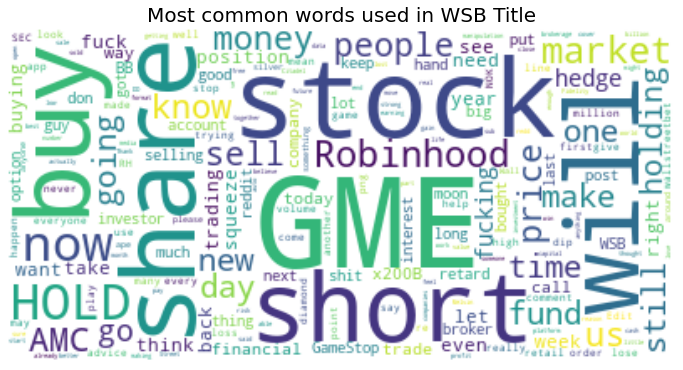

In [150]:
# Creating Word Cloud
# Words to not include in Word Clouds
my_stopwords = set(STOPWORDS)
# Additional phrases I don't want picked up in word clouds
my_stopwords.update(['https', 'http', '\n', '\t'])
title_wc = WordCloud(stopwords = my_stopwords,background_color='white', collocations = False).generate(text_all)
plt.figure(figsize=(12,10))
plt.imshow(title_wc, interpolation='bilinear')
plt.title('Most common words used in WSB Title', fontsize = 20)
plt.axis('off')

In [ ]:
### how many words from the beginning it appears

In [153]:
tokens = nltk.word_tokenize(text_all)   # tokenize it

In [154]:
mytext = nltk.Text(tokens)         # turn text into a NLTK Text object

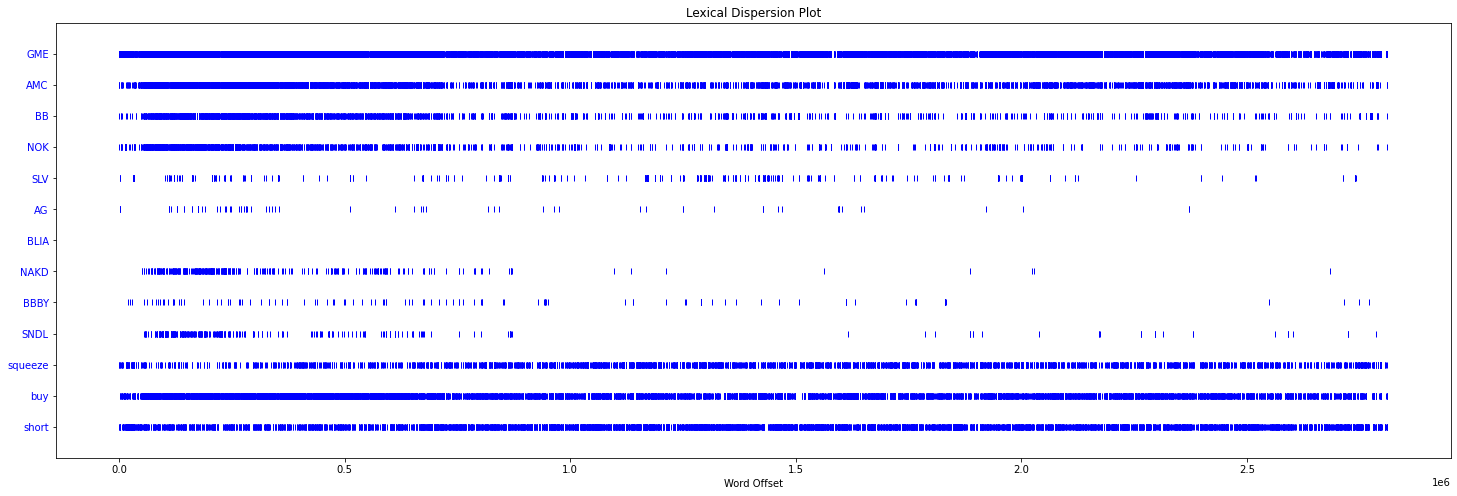

In [171]:
plt.figure(figsize=(25, 8))  # change figsize to (width, height), the size you want
mytext.dispersion_plot(["GME", "AMC", "BB", "NOK","SLV","AG","BLIA","NAKD","BBBY", "SNDL","squeeze", "buy", "short"])